The model consists of two diffrent parts
1. Feature extraction: using a DARKNET-53 (53 convolution layers with residual)



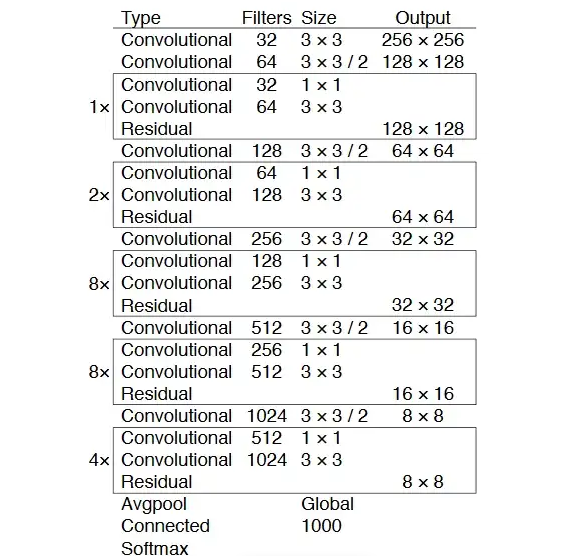

2. Bounding box prediction.

Since the paper does not describe fully the structure of the bounding box prediction we surfed the web instead and the github implementation: 

you can check here 
https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg

and here: 
https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b





why YOLOV3 is detecting bounding boxes on three different levels. The answer to this question is that three-level detection helps YOLOv3 detects different size objects more accurately. layers [79 -> 82]  make the output 32 times smaller than the actual image, layers [91 -> 94] makes 16 times smaller and layers [103 -> 106] makes 8 times smaller. So large objects get detected more frequently on layers [79 -> 82] , medium size object on layers [91 -> 94] and small objects on layer [103 -> 106]. This three-layer detection technique helps yolov3 to get better detection than previous variants.

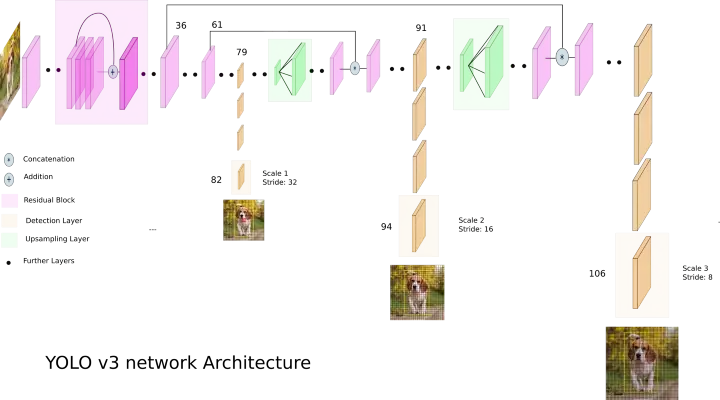

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
# every tuple is  a convolutional block (filters , kernal_size , stride)
# B is residual block with the number of repeats
# residual blocks as from the image above shre the same structure with a diffrent filters size which will be solved later
#S is for a scale prediction block and computing the yolo loss
#U is for upsampling the feature map
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    # first route from the end of the previous block
    (512, 3, 2),
    ["B", 8], 
    # second route from the end of the previous block
    (1024, 3, 2),
    ["B", 4],
    # until here is YOLO-53 that has been described in the paper
    #bounding box prediction (3 paths)
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [ ]:
class CNNBlock(nn.Module):
  #bn_act represents if the block going to use batch normalization or not 
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super(CNNBlock, self).__init__()
        #we don't use bias if we are using batch normalization in a residual block
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

In [ ]:
#down samples number of filters and bring it back up again 
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    #devide the channels by two
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + self.use_residual * x

        return x



In [ ]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
      #, anchors_per_scale
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            # 5 is the bounding box which is the p , x, y, w, h , 3 is for the number of anchors
            CNNBlock(2*in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1),
        )
        self.num_classes = num_classes
        #self.anchors_per_scale = anchors_per_scale

    def forward(self, x):
        return (
            self.pred(x)
            # splitting the output into multiple boding box 
                .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
                .permute(0, 1, 3, 4, 2)
        )

In [ ]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        #route connections is the concatination places so we keep tracl of it 
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                # to skip the branches in the model and continue with the layers after scale prediction
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
              #adding route_connection as in the main config file in the original implementation
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs


    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                #in_channels for next block is the output of the previous one 
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(
                    ResidualBlock(
                        in_channels,
                        num_repeats=num_repeats,
                    )
                )

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        #same behaviour in every scale prediction block , 
                        # which is usually using a residual block without the residual layer and repeat it once
                        #then add a convolution
                        # then scale prediction 
                        # this behavior can be seen from the config file of the main implementation since it was not mentioned explicitly in the paper
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(
                        nn.Upsample(scale_factor=2),
                    )
                    # the concatination part happens right after upsampling as explained in the image describing bounding box prediction
                    #concationation happens with the first layer in the concatination
                    in_channels = in_channels * 3

        return layers

    def load_CNN_weights(self, ptr, block):
        conv_layer = block.conv
        if block.use_bn_act:
            # Load BN bias, weights, running mean and running variance
            bn_layer = block.bn
            num_b = bn_layer.bias.numel()  # Number of biases
            # Bias
            bn_b = torch.from_numpy(self.weights[ptr : ptr + num_b]).view_as(
                bn_layer.bias
            )
            bn_layer.bias.data.copy_(bn_b)
            ptr += num_b
            # Weight
            bn_w = torch.from_numpy(self.weights[ptr : ptr + num_b]).view_as(
                bn_layer.weight
            )
            bn_layer.weight.data.copy_(bn_w)
            ptr += num_b
            # Running Mean
            bn_rm = torch.from_numpy(self.weights[ptr : ptr + num_b]).view_as(
                bn_layer.running_mean
            )
            bn_layer.running_mean.data.copy_(bn_rm)
            ptr += num_b
            # Running Var
            bn_rv = torch.from_numpy(self.weights[ptr : ptr + num_b]).view_as(
                bn_layer.running_var
            )
            bn_layer.running_var.data.copy_(bn_rv)
            ptr += num_b
        else:
            # Load conv. bias
            num_b = conv_layer.bias.numel()

            conv_b = torch.from_numpy(self.weights[ptr : ptr + num_b]).view_as(
                conv_layer.bias
            )
            conv_layer.bias.data.copy_(conv_b)
            ptr += num_b
            # Load conv. weights
        num_w = conv_layer.weight.numel()
        conv_w = torch.from_numpy(self.weights[ptr : ptr + num_w]).view_as(
            conv_layer.weight
        )
        conv_layer.weight.data.copy_(conv_w)
        ptr += num_w
        return ptr

    def load_darknet_weights(self, weights_path):
        #parse and load the Weights from the original yolov3.wei

        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(
                f, dtype=np.int32, count=5
            )  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            self.weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        ptr = 0
        for idx, layer in enumerate(self.layers):
            if isinstance(layer, CNNBlock):
                ptr = self.load_CNN_weights(ptr, layer)

            elif isinstance(layer, ResidualBlock):
                for i in range(layer.num_repeats):
                    ptr = self.load_CNN_weights(ptr, layer.layers[i][0])
                    ptr = self.load_CNN_weights(ptr, layer.layers[i][1])

            elif isinstance(layer, ScalePrediction):
                # print("Starting scale prediction route")
                cnn_block = layer.pred[0]
                last_block = layer.pred[1]
                ptr = self.load_CNN_weights(ptr, cnn_block)
                ptr = self.load_CNN_weights(ptr, last_block)

                # ptr = self.load_CNN_weights(ptr, cnn_block)
            # print("Scale prediction ")

        #print(ptr)

  


In [ ]:
#num_classes = 20
#num_classes = 80

image_size as we seen from the previous notebook that the image size was 448 in YoloV1 and it became 416 in YoloV3

In [ ]:
#image_size = 416

In [ ]:
#model = YOLOv3(num_classes = num_classes)

In [ ]:
#model

YOLOv3(
  (layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (1): CNNBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (2): ResidualBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): CNNBlock(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (leaky): LeakyReLU(negative_slope=0.1)
          )
          (1): CNNBlock(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

after checking the config file in:
https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg

we can see that our model match the model (in structure) mentioned in the config file of the main implementation of YOLO V3

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# %cd drive/MyDrive/ExamProject

[Errno 2] No such file or directory: 'drive/MyDrive/ExamProject'
/content/drive/MyDrive/ExamProject


In [ ]:
# !ls

 archive.zip			 Weights
 DataSet.py			 YOLO_DataSet.ipynb
 intersection_over_union.ipynb	 yolo_dataset.py
 intersection_over_union.py	 YoloV1_the_model.ipynb
 MeanAveragePrecision.ipynb	 yolov1_the_model.py
 MeanAveragePrecision.py	'YOLOv3 Intermidiate status report.pptx'
 Non_Max_Suppression.ipynb	 YOLOv3_loss_function.ipynb
 non_max_suppression.py		 yolov3_loss_function.py
 PASCAL_VOC			 YOLOV3_the_model.ipynb
 __pycache__			 YOLOV3_the_model.py
 Untitled.ipynb			'YOLOV3_the_model - withPreTrainedWeight.ipynb'


In [ ]:
#  model.load_darknet_weights(weights_path="Weights/yolov3.weights")

61678657
